In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Embedding,  BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/content/Amazon-Product-Review-Sentiment-Analysis-using-RNN-Dataset.csv')

print(data.shape)
print(data.info())

(25000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     24999 non-null  object
 1   Sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None


In [3]:
# looking for NULL values
print("Null Values:\n", data.isna().sum())

data = data.dropna()

# again checking for NULL values
print("Null Values after dropping:\n", data.isna().sum())

Null Values:
 Review       1
Sentiment    0
dtype: int64
Null Values after dropping:
 Review       0
Sentiment    0
dtype: int64


In [4]:
# count of unique values in Sentiment column
data['Sentiment'].value_counts()

,count
Sentiment,
1,5000
2,5000
3,5000
4,5000
5,4999


In [6]:
# downloading stopwords from nltk library
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# downloading punkt sentence tokenizer models
nltk.download('punkt')
nltk.download('punkt_tab')

# Review text Cleaning
def clean_reviews(text):

    # removing html brackets and other square brackets from the string using regex
    regex = re.compile('<.*?>') # r'<.*?>'
    text = re.sub(regex, '', text)

    # removing special characters like @, #, $, etc
    pattern = re.compile('[^a-zA-z0-9\s]')
    text = re.sub(pattern,'',text)

    # removing numbers
    pattern = re.compile('\d+')
    text = re.sub(pattern,'',text)
    text = text.lower()

    text = word_tokenize(text)
    text = [word for word in text if not word in stop_words]

    return text

data['Review'] = data['Review'].apply(clean_reviews)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [7]:
tokenizer = Tokenizer()

reviews_to_list = data['Review'].tolist()
tokenizer.fit_on_texts(reviews_to_list)

# Generating text sequences
text_sequences = tokenizer.texts_to_sequences(reviews_to_list)

# setting maximum words we want in an example
max_words = 500

padded_sequences = pad_sequences(text_sequences, maxlen=max_words)

text_sequences = np.array(padded_sequences)

# one hot encoding
data = pd.get_dummies(data, columns = ['Sentiment'])

X = pad_sequences(text_sequences, maxlen = max_words)
y = data[['Sentiment_1', 'Sentiment_2', 'Sentiment_3', 'Sentiment_4',
    'Sentiment_5']]
print(X.shape, y.shape)

(24999, 500) (24999, 5)


In [8]:
# Train Test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(19999, 500) (5000, 500) (19999, 5) (5000, 5)


In [12]:
# Creating a RNN model
rnn = Sequential(name="Simple_RNN")
rnn.add(Embedding(len(tokenizer.word_index)+1,
                        max_words,
                        input_length=max_words))

rnn.add(SimpleRNN(128,activation='relu',return_sequences=True))

rnn.add(SimpleRNN(64,activation='relu',return_sequences=False))

rnn.add(Dense(5, activation='softmax'))

# # printing model summary
# print(rnn.summary())


In [13]:
rnn.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

# Training the model
history = rnn.fit(X_train, y_train,
                        batch_size=64,
                        epochs=2,
                        verbose=1,
                          validation_data = (X_test, y_test))

# Printing model score on test data
print("Simple_RNN Score---> ", rnn.evaluate(X_test, y_test, verbose=1))

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 95ms/step - accuracy: 0.3001 - loss: 1.4891 - val_accuracy: 0.4364 - val_loss: 1.2668
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - accuracy: 0.5476 - loss: 1.0707 - val_accuracy: 0.4294 - val_loss: 1.3030
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4292 - loss: 1.3049
Simple_RNN Score--->  [1.302982211112976, 0.4293999969959259]


Text(0, 0.5, 'Accuracy')

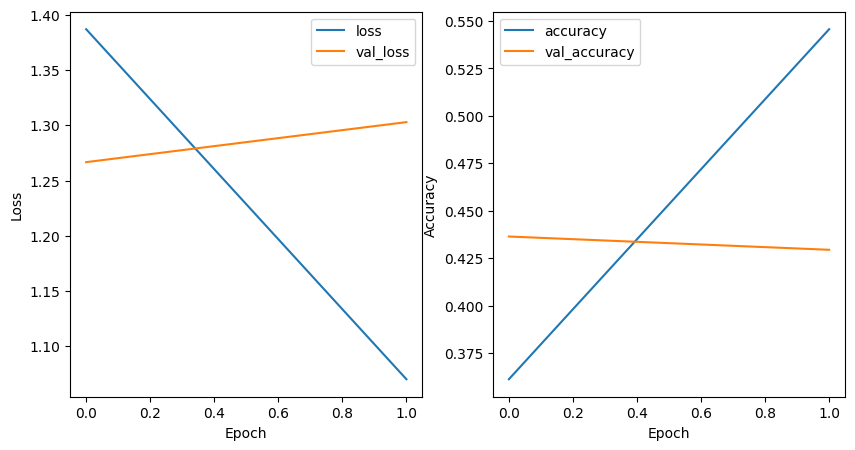

In [20]:
# Plotting the history
metrics = history.history
plt.figure(figsize=(10, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'],
         metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step


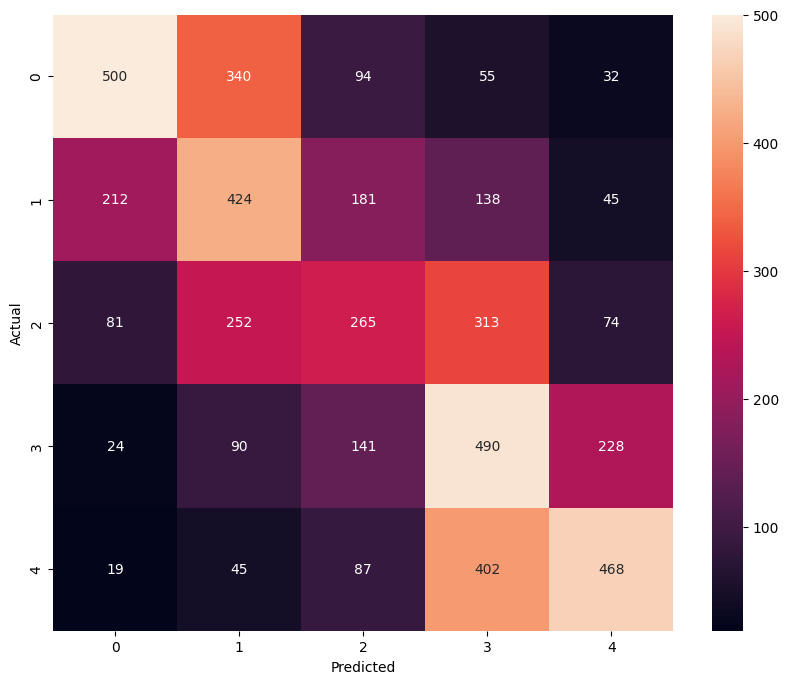

In [16]:
# converting y_test tht was one hot encoded to one column fo rconfusion matrix
y_true = np.argmax(y_test.values, axis=1)
y_true.shape

# Confusion matrix
y_pred = np.argmax(rnn.predict(X_test), axis=1)
cm = tf.math.confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [19]:
def predict_review_rating(text):
  text_sequences_test = np.array(tokenizer.texts_to_sequences([text]))
  testing = pad_sequences(text_sequences_test, maxlen = max_words)
  y_pred_test = np.argmax(rnn.predict(testing), axis=1)
  return y_pred_test[0]+1

# Testing
rating1 = predict_review_rating('dumb product')
print("The rating according to the review is: ", rating1)

rating2 = predict_review_rating('such a great product, I will recommend this to other users.')
print("The rating according to the review is: ", rating2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
The rating according to the review is:  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
The rating according to the review is:  5
